In [ ]:
!pip install datasets
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 12.2 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import os
import json
import numpy as np
from collections import Counter
from datasets import load_dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import nlpaug.augmenter.word as naw

In [ ]:
# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

# Load the dataset
print("Loading MMLU-Pro dataset...")
dataset = load_dataset("TIGER-Lab/MMLU-Pro")

# Extract questions and categories
preguntas = [item["question"] for item in dataset["test"]]
categorias = [item["category"] for item in dataset["test"]]

# Check category distribution
category_counts = Counter(categorias)
print("Category distribution:")
for category, count in category_counts.most_common():
    print(f"{category}: {count}")

# Get unique categories
categorias_unicas = list(set(categorias))
categorias_a_id = {categoria: i for i, categoria in enumerate(categorias_unicas)}

# Save category mapping
with open('categorias_a_id.json', 'w') as f:
    json.dump(categorias_a_id, f)

Loading MMLU-Pro dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.15M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/45.3k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/12032 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/70 [00:00<?, ? examples/s]

Category distribution:
math: 1351
physics: 1299
chemistry: 1132
law: 1101
engineering: 969
other: 924
economics: 844
health: 818
psychology: 798
business: 789
biology: 717
philosophy: 499
computer science: 410
history: 381


In [ ]:
# Format prompts with instructional prefix to improve model understanding
def format_prompt(question):
    return f"Classify the academic category: {question}"

# Apply prompt formatting
formatted_questions = [format_prompt(q) for q in preguntas]
category_ids = [categorias_a_id[cat] for cat in categorias]

# Use a better pre-trained model (SciBERT for scientific questions)
model_name = "allenai/scibert_scivocab_uncased"  # You can try other models like "roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Function to compute evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1
    }

# Dataset class for the model
class MMLUProDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Implement k-fold cross-validation for more reliable evaluation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_results = []

print(f"Starting {n_splits}-fold cross-validation...")

for fold, (train_idx, val_idx) in enumerate(kf.split(formatted_questions)):
    print(f"\nTraining fold {fold+1}/{n_splits}")

    # Split data for this fold
    fold_train_texts = [formatted_questions[i] for i in train_idx]
    fold_train_labels = [category_ids[i] for i in train_idx]
    fold_val_texts = [formatted_questions[i] for i in val_idx]
    fold_val_labels = [category_ids[i] for i in val_idx]

    # Simple data augmentation for training set
    print("Applying data augmentation...")
    aug = naw.SynonymAug(aug_src='wordnet')

    augmented_texts = []
    augmented_labels = []
    for text, label in zip(fold_train_texts[:100], fold_train_labels[:100]):  # Augment a subset to save time
        try:
            augmented_text = aug.augment(text)[0]
            augmented_texts.append(augmented_text)
            augmented_labels.append(label)
        except:
            continue  # Skip if augmentation fails

    # Combine original and augmented data
    fold_train_texts = fold_train_texts + augmented_texts
    fold_train_labels = fold_train_labels + augmented_labels

    # Tokenize data
    print("Tokenizing data...")
    train_encodings = tokenizer(fold_train_texts, truncation=True, padding=True, max_length=512)
    val_encodings = tokenizer(fold_val_texts, truncation=True, padding=True, max_length=512)

    # Create datasets
    train_dataset = MMLUProDataset(train_encodings, fold_train_labels)
    val_dataset = MMLUProDataset(val_encodings, fold_val_labels)

    # Compute class weights to handle imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(fold_train_labels), y=fold_train_labels)
    class_weights_dict = {i: float(weight) for i, weight in enumerate(class_weights)}

        # Create model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(categorias_unicas)
    )

    # Define training arguments with improvements
    training_args = TrainingArguments(
        output_dir=f'./results/fold_{fold+1}',
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=4,  # Effective batch size = 8*4 = 32
        num_train_epochs=5,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir=f'./logs/fold_{fold+1}',
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        fp16=True,  # Mixed precision training for faster execution
        report_to="none"  # Disable wandb explicitly
    )

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train the model
    print(f"Training model for fold {fold+1}...")
    trainer.train()

    # Evaluate on validation set
    print(f"Evaluating model for fold {fold+1}...")
    eval_result = trainer.evaluate()
    fold_results.append(eval_result)

    print(f"Fold {fold+1} results: {eval_result}")

    # Save the model for this fold
    model.save_pretrained(f"modelo_mmlu_fold_{fold+1}")
    tokenizer.save_pretrained(f"modelo_mmlu_fold_{fold+1}")

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

Starting 5-fold cross-validation...

Training fold 1/5
Applying data augmentation...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is al

Tokenizing data...


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training model for fold 1...


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.756800,0.657596,0.805152,0.802562
2,0.475300,0.522282,0.838388,0.836272
3,0.293100,0.474067,0.855837,0.855398
4,0.187000,0.480565,0.863731,0.863500
5,0.112700,0.487119,0.865808,0.865574


Evaluating model for fold 1...


Fold 1 results: {'eval_loss': 0.48711922764778137, 'eval_accuracy': 0.8658080598255089, 'eval_f1': 0.8655736368814165, 'eval_runtime': 18.558, 'eval_samples_per_second': 129.701, 'eval_steps_per_second': 8.137, 'epoch': 5.0}

Training fold 2/5
Applying data augmentation...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

Tokenizing data...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training model for fold 2...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.678500,0.680861,0.792273,0.792685
2,0.453400,0.563359,0.823432,0.822432
3,0.272200,0.497665,0.849605,0.849583
4,0.165200,0.517896,0.847943,0.847709
5,0.116300,0.524608,0.857499,0.857520


Evaluating model for fold 2...


Fold 2 results: {'eval_loss': 0.5246075391769409, 'eval_accuracy': 0.8574989613626921, 'eval_f1': 0.8575198667398689, 'eval_runtime': 18.3291, 'eval_samples_per_second': 131.321, 'eval_steps_per_second': 8.238, 'epoch': 5.0}

Training fold 3/5
Applying data augmentation...
Tokenizing data...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

Training model for fold 3...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.731900,0.675913,0.795511,0.794881
2,0.441600,0.558677,0.822111,0.829463
3,0.288500,0.492078,0.854530,0.853866
4,0.181400,0.487818,0.854946,0.854111
5,0.112500,0.491224,0.863674,0.862902


Evaluating model for fold 3...


Fold 3 results: {'eval_loss': 0.49122387170791626, 'eval_accuracy': 0.8636741479634248, 'eval_f1': 0.8629015872896408, 'eval_runtime': 18.3237, 'eval_samples_per_second': 131.306, 'eval_steps_per_second': 8.241, 'epoch': 5.0}

Training fold 4/5
Applying data augmentation...
Tokenizing data...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

Training model for fold 4...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.744800,0.663113,0.793849,0.793233
2,0.449100,0.529817,0.836658,0.836924
3,0.277800,0.484483,0.854530,0.854301
4,0.142700,0.496970,0.856608,0.856710
5,0.105200,0.512146,0.859102,0.859434


Evaluating model for fold 4...


Fold 4 results: {'eval_loss': 0.5121458172798157, 'eval_accuracy': 0.8591022443890274, 'eval_f1': 0.8594341520616665, 'eval_runtime': 18.4889, 'eval_samples_per_second': 130.132, 'eval_steps_per_second': 8.167, 'epoch': 5.0}

Training fold 5/5
Applying data augmentation...
Tokenizing data...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

Training model for fold 5...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.745000,0.621874,0.808396,0.805765
2,0.453200,0.487291,0.851205,0.850742
3,0.291400,0.472517,0.850790,0.851151
4,0.171500,0.479775,0.864090,0.864003
5,0.111900,0.498253,0.864090,0.864419


Evaluating model for fold 5...


Fold 5 results: {'eval_loss': 0.4982525706291199, 'eval_accuracy': 0.8640897755610972, 'eval_f1': 0.8644188854090169, 'eval_runtime': 18.2455, 'eval_samples_per_second': 131.868, 'eval_steps_per_second': 8.276, 'epoch': 5.0}


In [ ]:
# Print cross-validation results (SUBIR A LA CELDA DE ARRIBA)
print("\nCross-validation results:")
avg_accuracy = sum(result['eval_accuracy'] for result in fold_results) / len(fold_results)
avg_f1 = sum(result['eval_f1'] for result in fold_results) / len(fold_results)
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

# Train final model on entire dataset
print("\nTraining final model on entire dataset...")

# Format all questions
all_formatted_questions = [format_prompt(q) for q in preguntas]
all_labels = [categorias_a_id[cat] for cat in categorias]

# Use 90% for training, 10% for final validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    all_formatted_questions, all_labels, test_size=0.1, random_state=42, stratify=all_labels
)

# Apply data augmentation on training set
print("Applying data augmentation for final model...")
aug = naw.SynonymAug(aug_src='wordnet')
augmented_texts = []
augmented_labels = []
for text, label in zip(train_texts[:1000], train_labels[:1000]):  # Augment a subset
    try:
        augmented_text = aug.augment(text)[0]
        augmented_texts.append(augmented_text)
        augmented_labels.append(label)
    except:
        continue

# Combine original and augmented data
train_texts = train_texts + augmented_texts
train_labels = train_labels + augmented_labels

# Tokenize
print("Tokenizing data for final model...")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Create datasets
train_dataset = MMLUProDataset(train_encodings, train_labels)
val_dataset = MMLUProDataset(val_encodings, val_labels)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: float(weight) for i, weight in enumerate(class_weights)}


Cross-validation results:
Average Accuracy: 0.8620
Average F1 Score: 0.8620

Training final model on entire dataset...
Applying data augmentation for final model...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

Tokenizing data for final model...


In [ ]:

# Create final model
final_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(categorias_unicas)
)

# Training arguments for final model
final_training_args = TrainingArguments(
    output_dir='./results/final_model',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='./logs/final_model',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    fp16=True,
    report_to="none"
)

# Create trainer for final model
final_trainer = Trainer(
    model=final_model,
    args=final_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train final model
print("Training final model...")
final_trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training final model...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.821800,0.629166,0.810631,0.810730
2,0.496900,0.482736,0.851329,0.851785
3,0.302000,0.479787,0.861296,0.862007
4,0.107400,0.466117,0.870432,0.870322


TrainOutput(global_step=1690, training_loss=0.5196692122510199, metrics={'train_runtime': 1573.9733, 'train_samples_per_second': 34.397, 'train_steps_per_second': 1.074, 'total_flos': 1.4209527803904e+16, 'train_loss': 0.5196692122510199, 'epoch': 4.986706056129985})

In [ ]:
# Evaluate final model
print("Evaluating final model...")
final_eval_result = final_trainer.evaluate()
print(f"Final model evaluation: {final_eval_result}")

# Save the final model
print("Saving final model...")
final_model.save_pretrained("modelo_mmlu_final")
tokenizer.save_pretrained("modelo_mmlu_final")

# Create a pipeline for easy inference
from transformers import pipeline
print("Creating classification pipeline...")
clasificador = pipeline("text-classification", model="modelo_mmlu_final", tokenizer="modelo_mmlu_final")


Evaluating final model...


Final model evaluation: {'eval_loss': 0.45283401012420654, 'eval_accuracy': 0.8712624584717608, 'eval_f1': 0.8716906870414712, 'eval_runtime': 9.204, 'eval_samples_per_second': 130.813, 'eval_steps_per_second': 8.257, 'epoch': 4.986706056129985}
Saving final model...


Device set to use cuda:0


Creating classification pipeline...


In [ ]:
# Evaluate final model
print("Evaluating final model...")
final_eval_result = final_trainer.evaluate()
print(f"Final model evaluation: {final_eval_result}")

# Save the final model
print("Saving final model...")
final_model.save_pretrained("modelo_mmlu_final")
tokenizer.save_pretrained("modelo_mmlu_final")

# Create a pipeline for easy inference
from transformers import pipeline
print("Creating classification pipeline...")
clasificador = pipeline("text-classification", model="modelo_mmlu_final", tokenizer="modelo_mmlu_final")

# Test on a few examples
print("\nTesting the model with examples:")
test_questions = [
    "What is the capital of France?",
    "Who discovered America?",
    "What is an index fund?",
    "What is 2+2?",
    "What is the chemical symbol for water?",
    "Who wrote Hamlet?"
]

for question in test_questions:
    formatted_question = format_prompt(question)
    result = clasificador(formatted_question)
    label_id = int(result[0]['label'].split('_')[1])
    # Find category name from id
    category_name = [cat for cat, id_val in categorias_a_id.items() if id_val == label_id][0]
    print(f"Question: {question}")
    print(f"Predicted category: {category_name} (confidence: {result[0]['score']:.4f})\n")

Evaluating final model...


Final model evaluation: {'eval_loss': 0.45283401012420654, 'eval_accuracy': 0.8712624584717608, 'eval_f1': 0.8716906870414712, 'eval_runtime': 9.0867, 'eval_samples_per_second': 132.501, 'eval_steps_per_second': 8.364, 'epoch': 4.986706056129985}
Saving final model...


Device set to use cuda:0


Creating classification pipeline...

Testing the model with examples:
Question: What is the capital of France?
Predicted category: economics (confidence: 0.8844)

Question: Who discovered America?
Predicted category: other (confidence: 0.8581)

Question: What is an index fund?
Predicted category: other (confidence: 0.5467)

Question: What is 2+2?
Predicted category: math (confidence: 0.9904)

Question: What is the chemical symbol for water?
Predicted category: chemistry (confidence: 0.9628)

Question: Who wrote Hamlet?
Predicted category: other (confidence: 0.9433)



In [ ]:

# Function to evaluate model on a larger test set
def evaluate_model_performance(model_path, test_data, test_labels, category_mapping):
    """Evaluate model performance on a test set"""
    # Create a classification pipeline
    test_classifier = pipeline("text-classification", model=model_path, tokenizer=model_path)

    # Get predictions
    predictions = []
    for question in test_data:
        formatted_question = format_prompt(question)
        result = test_classifier(formatted_question, truncation=True, max_length=512)
        label_id = int(result[0]['label'].split('_')[1])
        predictions.append(label_id)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)

    # Get classification report
    id_to_category = {v: k for k, v in category_mapping.items()}
    target_names = [id_to_category[i] for i in range(len(id_to_category))]

    report = classification_report(test_labels, predictions, target_names=target_names, output_dict=True)

    return accuracy, report

# Evaluate final model on a separate test set
print("\nEvaluating final model on test set...")
_, test_texts, _, test_labels = train_test_split(
    all_formatted_questions, all_labels, test_size=0.2, random_state=24, stratify=all_labels
)

accuracy, report = evaluate_model_performance("modelo_mmlu_final", test_texts, test_labels, categorias_a_id)
print(f"Test set accuracy: {accuracy:.4f}")
print("Performance by category:")
for category, metrics in report.items():
    if category not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"{category}: F1-score = {metrics['f1-score']:.4f}, Precision = {metrics['precision']:.4f}, Recall = {metrics['recall']:.4f}")

print("\nTraining and evaluation complete!")

Device set to use cuda:0



Evaluating final model on test set...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Test set accuracy: 0.9680
Performance by category:
economics: F1-score = 0.9733, Precision = 0.9762, Recall = 0.9704
law: F1-score = 0.9954, Precision = 1.0000, Recall = 0.9909
engineering: F1-score = 0.9896, Precision = 0.9948, Recall = 0.9845
math: F1-score = 0.9740, Precision = 0.9776, Recall = 0.9704
physics: F1-score = 0.9650, Precision = 0.9764, Recall = 0.9538
other: F1-score = 0.9366, Precision = 0.9551, Recall = 0.9189
business: F1-score = 0.9477, Precision = 0.9222, Recall = 0.9747
philosophy: F1-score = 0.9802, Precision = 0.9706, Recall = 0.9900
biology: F1-score = 0.9645, Precision = 0.9784, Recall = 0.9510
psychology: F1-score = 0.9451, Precision = 0.9226, Recall = 0.9688
history: F1-score = 0.9801, Precision = 0.9867, Recall = 0.9737
health: F1-score = 0.9755, Precision = 0.9815, Recall = 0.9695
computer science: F1-score = 0.9818, Precision = 0.9759, Recall = 0.9878
chemistry: F1-score = 0.9542, Precision = 0.9399, Recall = 0.9690

Training and evaluation complete!


In [ ]:
# Zip the model files
!zip -r modelo_mmlu_final.zip modelo_mmlu_final/

  adding: modelo_mmlu_final/ (stored 0%)
  adding: modelo_mmlu_final/config.json (deflated 59%)
  adding: modelo_mmlu_final/model.safetensors (deflated 7%)
  adding: modelo_mmlu_final/tokenizer_config.json (deflated 74%)
  adding: modelo_mmlu_final/vocab.txt (deflated 52%)
  adding: modelo_mmlu_final/special_tokens_map.json (deflated 42%)
  adding: modelo_mmlu_final/tokenizer.json (deflated 71%)


Device set to use cuda:0



Generando matriz de confusión para el modelo final...


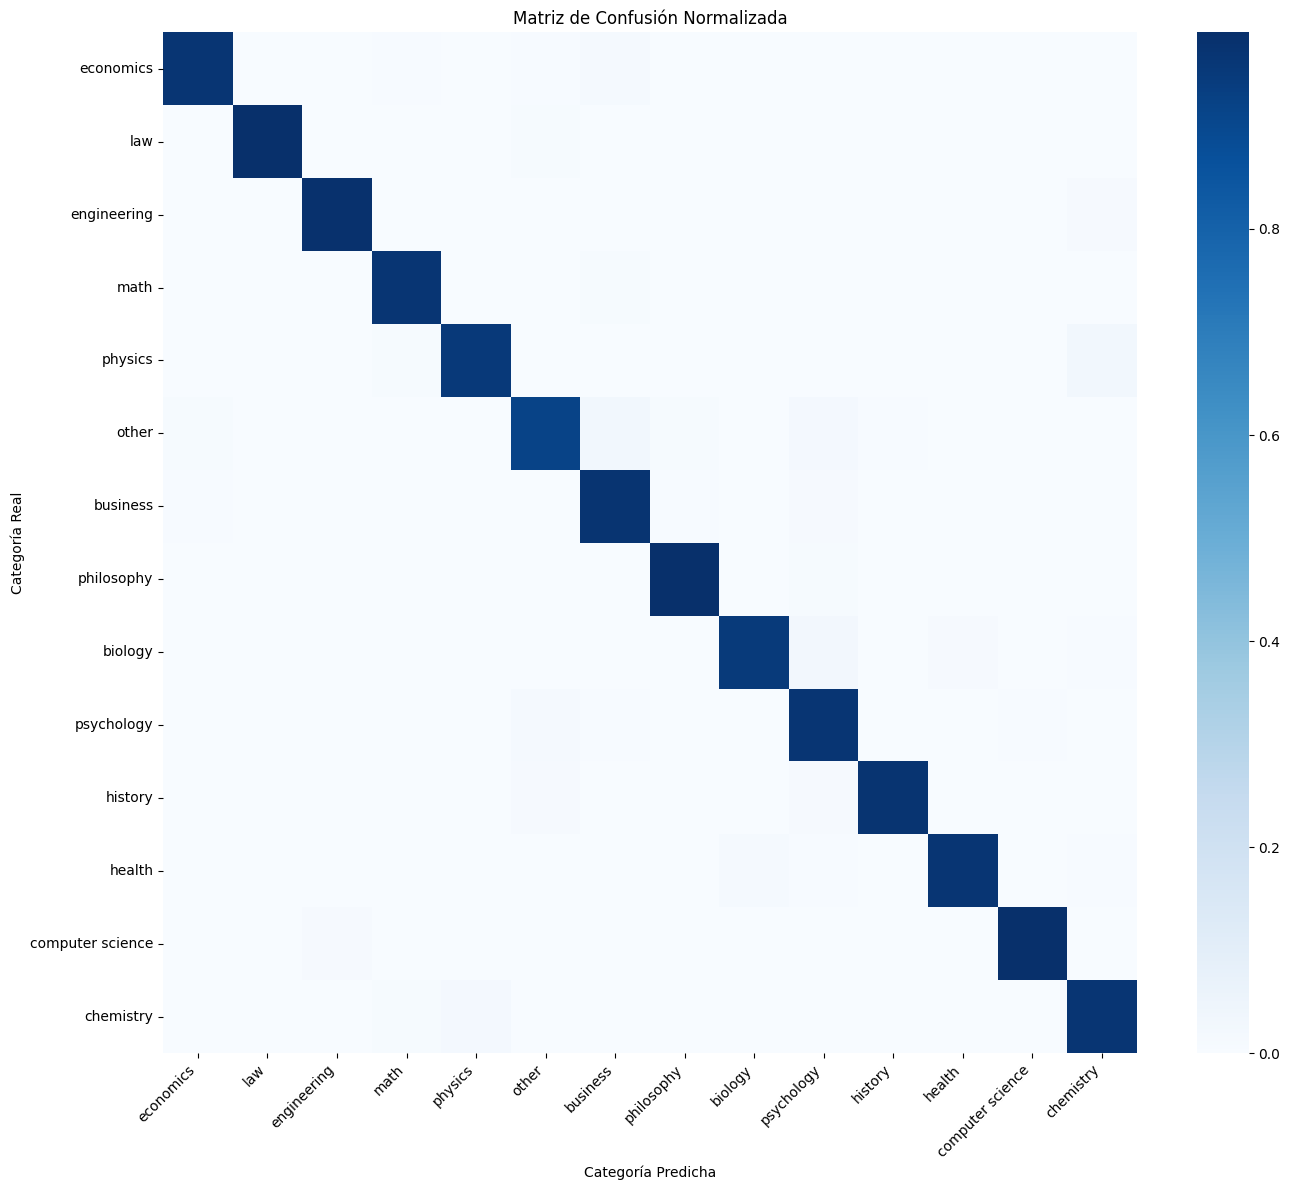


Top 5 pares de categorías más confundidas:
Real: physics → Predicción: chemistry (Confusiones: 9)
Real: other → Predicción: business (Confusiones: 6)
Real: chemistry → Predicción: physics (Confusiones: 5)
Real: other → Predicción: psychology (Confusiones: 4)
Real: biology → Predicción: psychology (Confusiones: 4)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Función para visualizar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, category_mapping):
    # Crear mapeo inverso de id a categoría
    id_to_category = {v: k for k, v in category_mapping.items()}

    # Obtener nombres de clases ordenados por id
    class_names = [id_to_category[i] for i in range(len(id_to_category))]

    # Calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Normalizar la matriz para obtener porcentajes
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Configurar tamaño de la figura según el número de categorías
    plt.figure(figsize=(14, 12))

    # Crear heatmap
    sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    # Añadir etiquetas y título
    plt.ylabel('Categoría Real')
    plt.xlabel('Categoría Predicha')
    plt.title('Matriz de Confusión Normalizada')

    # Ajustar etiquetas para mejor visualización
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Guardar la matriz como imagen
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

    # Mostrar la matriz
    plt.show()


# Evaluar el modelo final y generar matriz de confusión
print("\nGenerando matriz de confusión para el modelo final...")

# Crear un classification pipeline para obtener predicciones
test_classifier = pipeline("text-classification", model="modelo_mmlu_final", tokenizer="modelo_mmlu_final")

# Obtener predicciones para el conjunto de prueba
predictions = []
for question in test_texts:
    formatted_question = format_prompt(question)
    result = test_classifier(formatted_question, truncation=True, max_length=512)
    label_id = int(result[0]['label'].split('_')[1])
    predictions.append(label_id)

# Cargar el mapeo de categorías desde el archivo
with open('categorias_a_id.json', 'r') as f:
    categorias_a_id = json.load(f)

# Visualizar la matriz de confusión
plot_confusion_matrix(test_labels, predictions, categorias_a_id)

# También podemos mostrar las categorías más confundidas
cm = confusion_matrix(test_labels, predictions)
id_to_category = {v: k for k, v in categorias_a_id.items()}

print("\nTop 5 pares de categorías más confundidas:")
confusion_pairs = []

for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:  # No incluir la diagonal (predicciones correctas)
            confusion_pairs.append(((i, j), cm[i, j]))

# Ordenar por número de confusiones (de mayor a menor)
confusion_pairs.sort(key=lambda x: x[1], reverse=True)

# Mostrar los 5 pares más confundidos
for (true_id, pred_id), count in confusion_pairs[:5]:
    true_category = id_to_category[true_id]
    pred_category = id_to_category[pred_id]
    print(f"Real: {true_category} → Predicción: {pred_category} (Confusiones: {count})")

Device set to use cuda:0


Preguntas tras el filtrado: 998
Tasa de aciertos: 68.94%


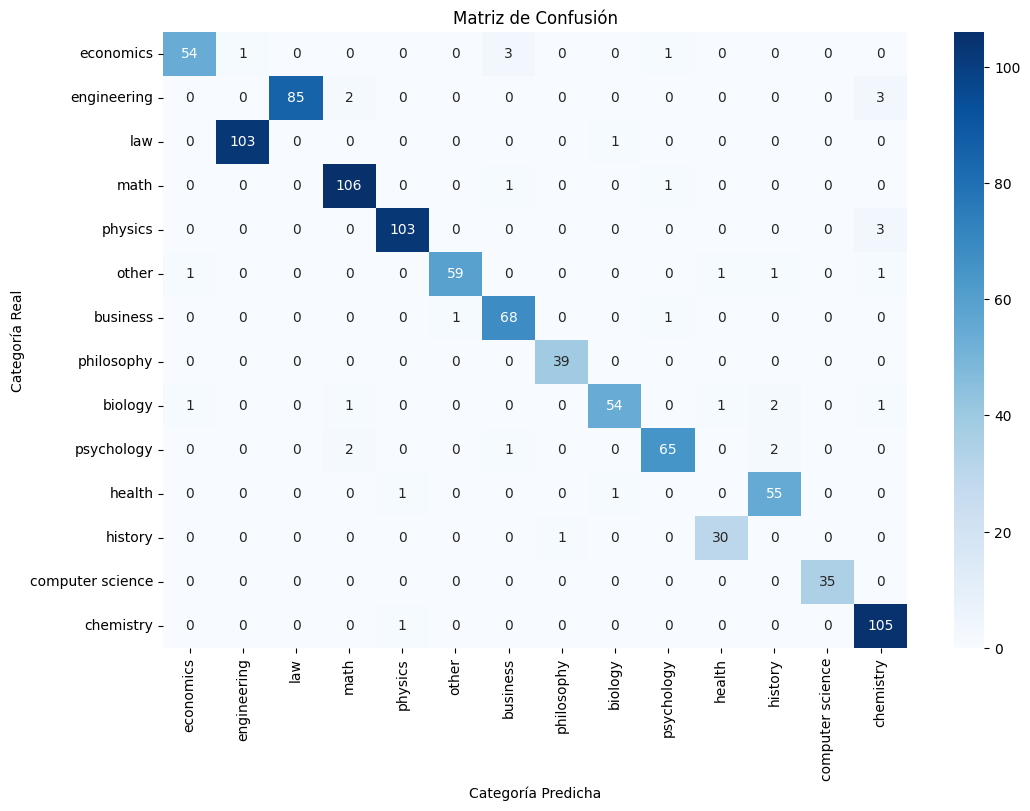

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from transformers import pipeline
from datasets import load_dataset
from random import sample

# Cargar el dataset
dataset = load_dataset("TIGER-Lab/MMLU-Pro")
val_dataset = dataset["test"]
random_val_dataset = sample(list(val_dataset), 1000)

clasificador = pipeline("text-classification", model="modelo_mmlu_final", tokenizer="modelo_mmlu_final", device=0)

# Filtrar preguntas largas
def filtrar_preguntas(dataset, max_tokens=512):
    preguntas_filtradas = []
    for item in dataset:
        num_tokens = len(clasificador.tokenizer.encode(item["question"], truncation=False))
        if num_tokens <= max_tokens:
            preguntas_filtradas.append(item)
    return preguntas_filtradas

dataset_filtrado = filtrar_preguntas(random_val_dataset)
print(f"Preguntas tras el filtrado: {len(dataset_filtrado)}")

# Obtener todas las categorías únicas
categorias_prueba = list(set(item["category"] for item in dataset_filtrado))
categorias_a_id_prueba = {categoria: i for i, categoria in enumerate(categorias_prueba)}
id_a_categorias_prueba = {i: categoria for categoria, i in categorias_a_id_prueba.items()}

# Obtener predicciones del modelo
predicciones = []
categorias_reales = []

for item in dataset_filtrado:
    pregunta = item["question"]
    categoria_real = categorias_a_id_prueba[item["category"]]

    resultado = clasificador(pregunta, truncation=True, max_length=512)  # Truncar la entrada
    etiqueta_predicha = int(resultado[0]['label'].split('_')[1])  # Convertir LABEL_X a número
    categorias_reales.append(categoria_real)
    predicciones.append(etiqueta_predicha)

# Calcular la precisión
tasa_aciertos = accuracy_score(categorias_reales, predicciones)
print(f"Tasa de aciertos: {tasa_aciertos * 100:.2f}%")

# Crear la matriz de confusión
matriz_confusion = confusion_matrix(categorias_reales, predicciones)

# Visualizar la matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=categorias_prueba, yticklabels=categorias_prueba)
plt.xlabel("Categoría Predicha")
plt.ylabel("Categoría Real")
plt.title("Matriz de Confusión")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Guardar la matriz como imagen
plt.savefig('confusion_matrix_2.png', dpi=300, bbox_inches='tight')


Cargando dataset MMLU-Pro...


Device set to use cuda:0


Cargando modelo...
Filtrando preguntas largas...
Preguntas tras el filtrado: 997
Obteniendo predicciones...
Tasa de aciertos: 98.29%


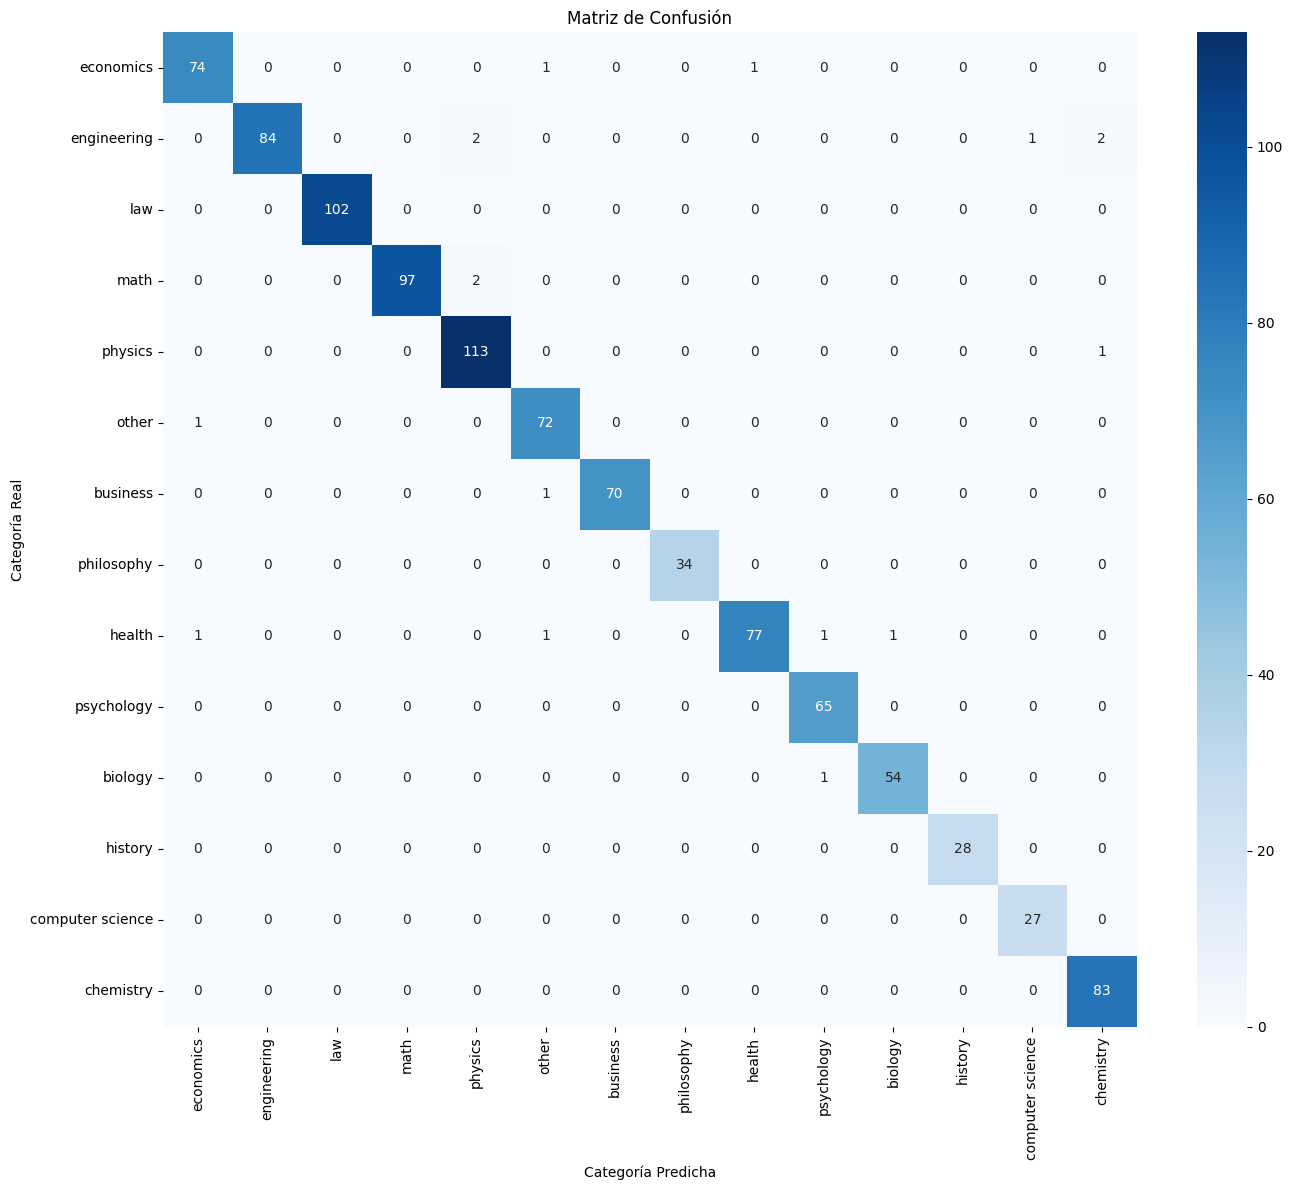


Top 5 pares de categorías más confundidas:
Real: engineering → Predicción: physics (Confusiones: 2)
Real: engineering → Predicción: chemistry (Confusiones: 2)
Real: math → Predicción: physics (Confusiones: 2)
Real: economics → Predicción: other (Confusiones: 1)
Real: economics → Predicción: health (Confusiones: 1)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import json
import numpy as np
from datasets import load_dataset
from transformers import pipeline
from random import sample

# Cargar el dataset
print("Cargando dataset MMLU-Pro...")
dataset = load_dataset("TIGER-Lab/MMLU-Pro")
val_dataset = dataset["test"]
random_val_dataset = sample(list(val_dataset), 1000)  # Muestrear 1000 ejemplos aleatorios

# Cargar el modelo y tokenizer
print("Cargando modelo...")
clasificador = pipeline("text-classification", model="modelo_mmlu_final", tokenizer="modelo_mmlu_final")

# Cargar el mapeo de categorías
with open('categorias_a_id.json', 'r') as f:
    categorias_a_id = json.load(f)
    id_a_categorias = {v: k for k, v in categorias_a_id.items()}

# Filtrar preguntas largas
def filtrar_preguntas(dataset, max_tokens=512):
    preguntas_filtradas = []
    for item in dataset:
        num_tokens = len(clasificador.tokenizer.encode(item["question"], truncation=False))
        if num_tokens <= max_tokens:
            preguntas_filtradas.append(item)
    return preguntas_filtradas

print("Filtrando preguntas largas...")
dataset_filtrado = filtrar_preguntas(random_val_dataset)
print(f"Preguntas tras el filtrado: {len(dataset_filtrado)}")

# Función para formatear la pregunta
def format_prompt(question):
    return f"Classify the academic category: {question}"

# Obtener todas las categorías únicas del dataset filtrado
categorias_prueba = list(set(item["category"] for item in dataset_filtrado))
categorias_a_id_prueba = {categoria: i for i, categoria in enumerate(categorias_prueba)}
id_a_categorias_prueba = {i: categoria for categoria, i in categorias_a_id_prueba.items()}

# Obtener predicciones del modelo
print("Obteniendo predicciones...")
predicciones = []
categorias_reales = []

for item in dataset_filtrado:
    pregunta = item["question"]
    pregunta_formateada = format_prompt(pregunta)
    categoria_real = categorias_a_id_prueba[item["category"]]

    resultado = clasificador(pregunta_formateada, truncation=True, max_length=512)
    etiqueta_predicha = int(resultado[0]['label'].split('_')[1])  # Convertir LABEL_X a número

    # Mapear el ID predicho a la categoría correspondiente en el conjunto de prueba
    # Esto es necesario porque los IDs pueden ser diferentes entre entrenamiento y prueba
    categoria_predicha_nombre = id_a_categorias[etiqueta_predicha]
    if categoria_predicha_nombre in categorias_a_id_prueba:
        etiqueta_predicha_mapeada = categorias_a_id_prueba[categoria_predicha_nombre]
    else:
        # Si la categoría no existe en el conjunto de prueba, asignar un valor no válido
        etiqueta_predicha_mapeada = -1
        print(f"Advertencia: Categoría '{categoria_predicha_nombre}' no encontrada en conjunto de prueba")

    categorias_reales.append(categoria_real)
    predicciones.append(etiqueta_predicha_mapeada)

# Filtrar predicciones no válidas
indices_validos = [i for i, pred in enumerate(predicciones) if pred != -1]
predicciones_filtradas = [predicciones[i] for i in indices_validos]
categorias_reales_filtradas = [categorias_reales[i] for i in indices_validos]

# Calcular la precisión
if predicciones_filtradas:
    tasa_aciertos = accuracy_score(categorias_reales_filtradas, predicciones_filtradas)
    print(f"Tasa de aciertos: {tasa_aciertos * 100:.2f}%")
else:
    print("No hay predicciones válidas para calcular la precisión")

# Crear la matriz de confusión
matriz_confusion = confusion_matrix(categorias_reales_filtradas, predicciones_filtradas)

# Preparar etiquetas para la matriz
etiquetas = [id_a_categorias_prueba[i] for i in range(len(id_a_categorias_prueba))]

# Visualizar la matriz de confusión
plt.figure(figsize=(14, 12))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel("Categoría Predicha")
plt.ylabel("Categoría Real")
plt.title("Matriz de Confusión")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('matriz_confusion.png', dpi=300, bbox_inches='tight')

# Guardar la matriz como imagen
plt.savefig('confusion_matrix_3.png', dpi=300, bbox_inches='tight')

plt.show()

# Calcular y mostrar las categorías más confundidas
print("\nTop 5 pares de categorías más confundidas:")
confusion_pairs = []

for i in range(len(matriz_confusion)):
    for j in range(len(matriz_confusion)):
        if i != j:  # No incluir la diagonal (predicciones correctas)
            confusion_pairs.append(((i, j), matriz_confusion[i, j]))

# Ordenar por número de confusiones (de mayor a menor)
confusion_pairs.sort(key=lambda x: x[1], reverse=True)

# Mostrar los 5 pares más confundidos
for (true_id, pred_id), count in confusion_pairs[:5]:
    if count > 0:  # Solo mostrar si hay confusiones
        true_category = id_a_categorias_prueba[true_id]
        pred_category = id_a_categorias_prueba[pred_id]
        print(f"Real: {true_category} → Predicción: {pred_category} (Confusiones: {count})")